In [1]:
pwd

'/home/jovyan'

In [2]:
!pip install rdkit-pypi
!pip install scikit-learn

In [3]:
# import modules
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# read BBBP.csv file
df = pd.read_csv('BBBP.csv')
df.head()

,num,name,p_np,smiles
0,1,Propanolol,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12
1,2,Terbutylchlorambucil,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl
2,3,40730,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...
3,4,24,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C
4,5,cloxacillin,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...


In [5]:
df.shape

(2050, 4)

In [6]:
# split training, validation, and test set into 8:1:1 ratio
from sklearn.model_selection import train_test_split
train, temp = train_test_split(df, test_size=0.2, random_state=2023)
test, val = train_test_split(temp, test_size=0.5, random_state=2023)

# verify length of each set
print("Training set length: ", len(train))
print("Validation set length: ", len(val))
print("Test set length: ", len(test))

Training set length:  1640
Validation set length:  205
Test set length:  205


In [7]:
# calculate morgan fingerprint for each molecule from BBBP.csv
# append both lists if mol != None
Morgan_fpts = []
p_np = []
for i in range(len(df)):
    mol = Chem.MolFromSmiles(df['smiles'][i])
    if mol != None:
        Morgan_fpts.append(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024))
        p_np.append(df['p_np'][i])

[19:13:16] Explicit valence for atom # 1 N, 4, is greater than permitted
[19:13:16] WARNING: not removing hydrogen atom without neighbors
[19:13:16] Explicit valence for atom # 6 N, 4, is greater than permitted
[19:13:16] WARNING: not removing hydrogen atom without neighbors
[19:13:16] WARNING: not removing hydrogen atom without neighbors
[19:13:16] WARNING: not removing hydrogen atom without neighbors
[19:13:16] WARNING: not removing hydrogen atom without neighbors
[19:13:16] WARNING: not removing hydrogen atom without neighbors
[19:13:16] WARNING: not removing hydrogen atom without neighbors
[19:13:16] Explicit valence for atom # 6 N, 4, is greater than permitted
[19:13:16] WARNING: not removing hydrogen atom without neighbors
[19:13:16] WARNING: not removing hydrogen atom without neighbors
[19:13:16] WARNING: not removing hydrogen atom without neighbors
[19:13:16] WARNING: not removing hydrogen atom without neighbors
[19:13:16] Explicit valence for atom # 11 N, 4, is greater than pe

In [8]:
# get lengths of each list
print("Morgan_fpts length: ", len(Morgan_fpts))
print("p_np length: ", len(p_np))

Morgan_fpts length:  2039
p_np length:  2039


In [9]:
# convert fingerprints to numpy array
Morgan_fpts = np.array(Morgan_fpts)

In [10]:
# convert p_np to numpy array
p_np = np.array(p_np)

In [11]:
# define one instance of a molecule as some_mol
some_mol = Morgan_fpts[0]

In [12]:
# use stochastic gradient descent (SGD) classifier to handle large datasets efficiently 
# train on the whole training set
from sklearn.linear_model import SGDClassifier

# target vectors
train_mol = (p_np == 1)
val_mol = (p_np == 1)
test_mol = (p_np == 1)

sgd_clf = SGDClassifier(random_state=2023)
sgd_clf.fit(Morgan_fpts, p_np)

SGDClassifier(random_state=2023)

In [13]:
# use cross_val_predict() function to perform k-fold cross-validation and return predictions made on each test 
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, Morgan_fpts, p_np, cv=3)

In [14]:
# get confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(p_np, y_train_pred)

array([[ 226,  253],
       [ 149, 1411]])

In [15]:
# compute precision and recall
from sklearn.metrics import precision_score, recall_score
precision_score(p_np, y_train_pred)
recall_score(p_np, y_train_pred)

0.9044871794871795

In [16]:
recall_score(p_np, y_train_pred)

0.9044871794871795

In [17]:
# compute f1 score
from sklearn.metrics import f1_score
f1_score(p_np, y_train_pred)

0.8753101736972705

In [18]:
# check decision scores and return scores for each instance
y_scores = sgd_clf.decision_function([some_mol])
y_scores

array([-1.00373845])

In [19]:
# get scores of all instances in the training set 
# return decision scores instead of predictions
y_scores = cross_val_predict(sgd_clf,Morgan_fpts, p_np, cv=3,
                             method="decision_function")
y_scores

array([ -4.32720047,  14.66379945,   9.98485744, ...,  -0.0515254 ,
         4.32729752, -16.60894956])

In [20]:
# compute precision and recall for all possible thresholds
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(p_np, y_scores)

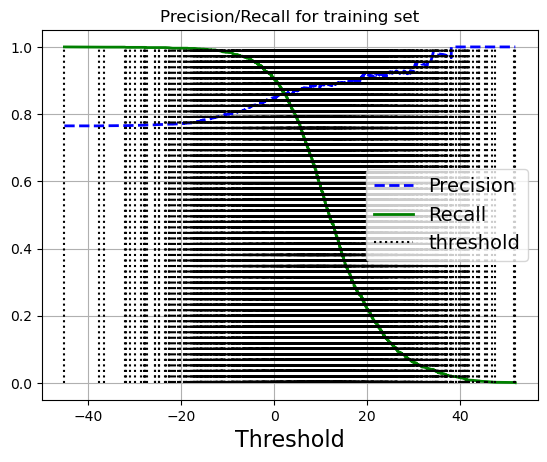

In [21]:
# plot precision and recall as functions of the threshold value using matplotlib
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(thresholds, 0, 1.0, "k", "dotted", label="threshold")
# beautify the figure: add grid, legend, axis, labels, and circles
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.xlabel("Threshold", fontsize=16)
plt.title("Precision/Recall for training set")
plt.show()

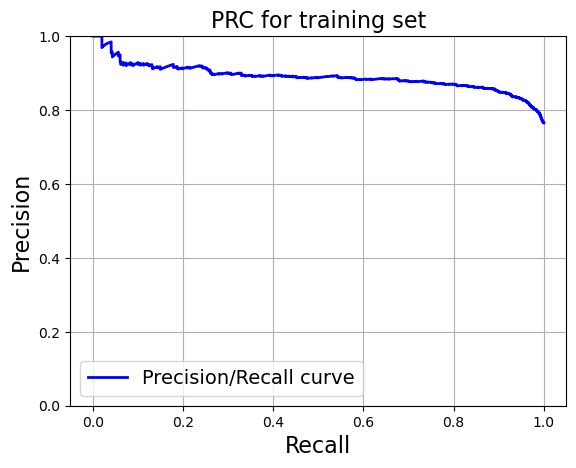

In [22]:
# create a precision-recall curve using matplotlib
plt.plot(recalls, precisions, "b-", linewidth=2, label="Precision/Recall curve")
# beautify the figure: add grid, legend, axis, labels, and circles
plt.grid(True)
plt.legend(loc="lower left", fontsize=14)
plt.xlabel("Recall", fontsize=16)
plt.ylabel("Precision", fontsize=16)
plt.title("PRC for training set", fontsize=16)
plt.axis([-0.05, 1.05, 0, 1])
plt.show()

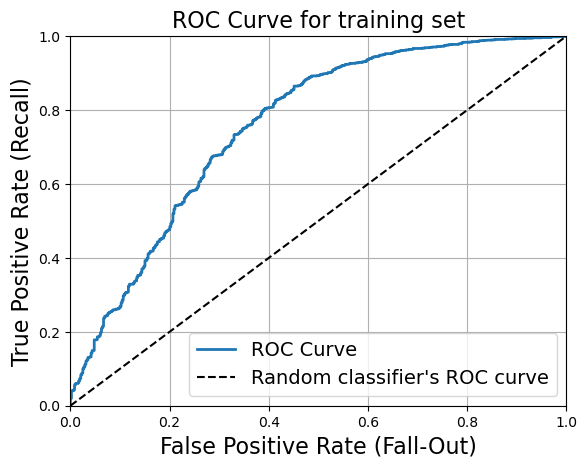

In [23]:
# plot ROC curve using matplotlib
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(p_np, y_scores)

plt.plot(fpr, tpr, linewidth=2, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label="Random classifier's ROC curve") # dashed diagonal
# beautify the figure: add grid, legend, axis, labels, and circles
plt.grid(True)
plt.legend(loc="lower right", fontsize=14)
plt.xlabel("False Positive Rate (Fall-Out)", fontsize=16)
plt.ylabel("True Positive Rate (Recall)", fontsize=16)
plt.title("ROC Curve for training set", fontsize=16)
plt.axis([0, 1, 0, 1])
plt.show()

In [24]:
# estimate AUC of ROC curve
from sklearn.metrics import roc_auc_score
roc_auc_score(p_np, y_scores)

0.7571155184411968

In [25]:
# repeat steps above for validation set
y_scores_val = cross_val_predict(sgd_clf, Morgan_fpts, p_np, cv=3, method="decision_function")
y_scores_val

array([ -4.32720047,  14.66379945,   9.98485744, ...,  -0.0515254 ,
         4.32729752, -16.60894956])

In [26]:
# compute precision and recall for all possible thresholds
precisions_val, recalls_val, thresholds_val = precision_recall_curve(p_np, y_scores_val)

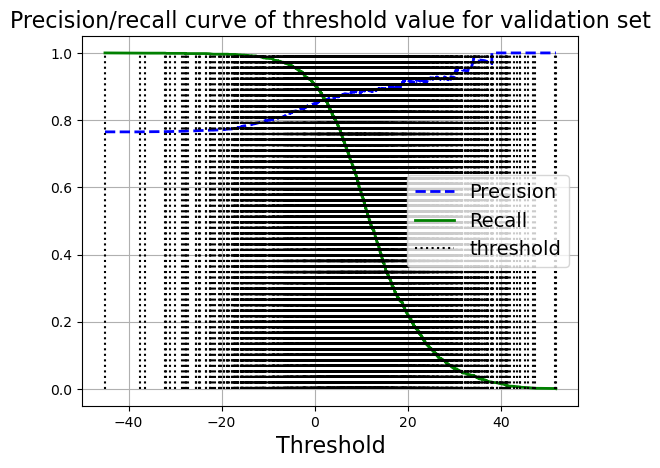

In [27]:
# plot precision and recall as functions of the threshold value using matplotlib
# display only
plt.plot(thresholds_val, precisions_val[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds_val, recalls_val[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(thresholds_val, 0, 1.0, "k", "dotted", label="threshold")
# beautify the figure: add grid, legend, axis, labels, and circles
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.xlabel("Threshold", fontsize=16)
plt.title("Precision/recall curve of threshold value for validation set", fontsize=16)
plt.show()

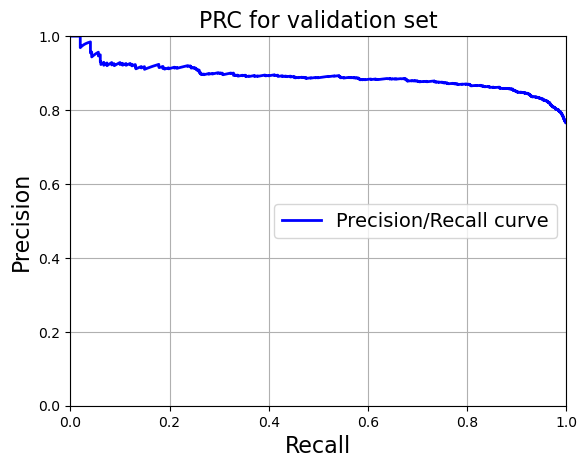

In [28]:
# create a precision-recall curve using matplotlib
plt.plot(recalls_val, precisions_val, "b-", linewidth=2, label='Precision/Recall curve')
# beautify the figure: add grid, legend, axis, labels, and circles
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.xlabel("Recall", fontsize=16)
plt.ylabel("Precision", fontsize=16)
plt.title("PRC for validation set", fontsize=16)
plt.axis([0, 1, 0, 1])
plt.show()

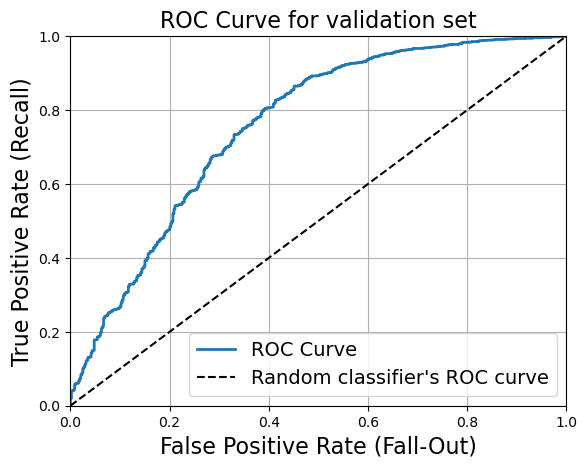

In [29]:
# plot ROC curve using matplotlib
fpr_val, tpr_val, thresholds_val = roc_curve(p_np, y_scores_val)
plt.plot(fpr_val, tpr_val, linewidth=2, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label="Random classifier's ROC curve") # dashed diagonal
# beautify the figure: add grid, legend, axis, labels, and circles
plt.grid(True)
plt.legend(loc="lower right", fontsize=14)
plt.xlabel("False Positive Rate (Fall-Out)", fontsize=16)
plt.ylabel("True Positive Rate (Recall)", fontsize=16)
plt.title("ROC Curve for validation set", fontsize=16)
plt.axis([0, 1, 0, 1])
plt.show()

In [30]:
# estimate ROC-AUC score
roc_auc_score(p_np, y_scores_val)

0.7571155184411968

In [31]:
# repeat steps above for test set
y_scores_test = cross_val_predict(sgd_clf, Morgan_fpts, p_np, cv=3, method="decision_function")
y_scores_test

array([ -4.32720047,  14.66379945,   9.98485744, ...,  -0.0515254 ,
         4.32729752, -16.60894956])

In [32]:
# compute precision and recall for all possible thresholds
precisions_test, recalls_test, thresholds_test = precision_recall_curve(p_np, y_scores_test)

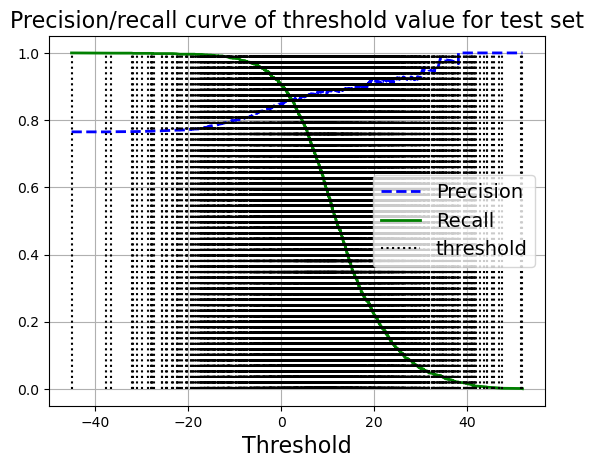

In [33]:
# plot precision and recall as functions of the threshold value using matplotlib
# display only
plt.plot(thresholds_test, precisions_test[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds_test, recalls_test[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(thresholds_test, 0, 1.0, "k", "dotted", label="threshold")
# beautify the figure: add grid, legend, axis, labels, and circles
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.xlabel("Threshold", fontsize=16)
plt.title("Precision/recall curve of threshold value for test set", fontsize=16)
plt.show()

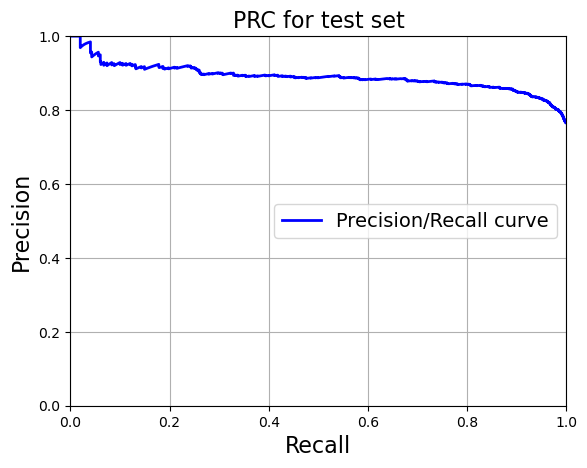

In [34]:
# create a precision-recall curve using matplotlib
plt.plot(recalls_test, precisions_test, "b-", linewidth=2, label='Precision/Recall curve')
# beautify the figure: add grid, legend, axis, labels, and circles
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.xlabel("Recall", fontsize=16)
plt.ylabel("Precision", fontsize=16)
plt.title("PRC for test set", fontsize=16)
plt.axis([0, 1, 0, 1])
plt.show()

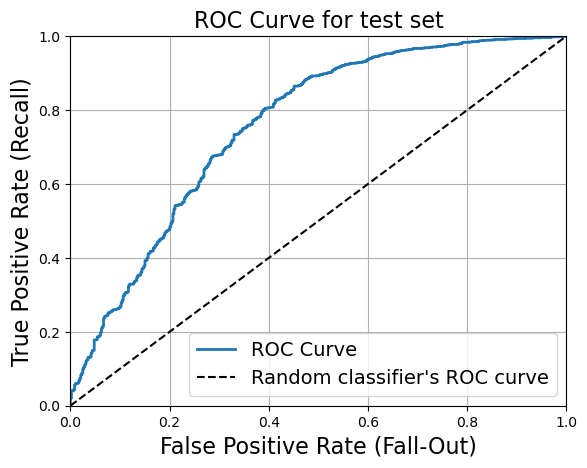

In [35]:
# plot ROC curve using matplotlib
fpr_test, tpr_test, thresholds_test = roc_curve(p_np, y_scores_test)
plt.plot(fpr_test, tpr_test, linewidth=2, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label="Random classifier's ROC curve") # dashed diagonal
# beautify the figure: add grid, legend, axis, labels, and circles
plt.grid(True)
plt.legend(loc="lower right", fontsize=14)
plt.xlabel("False Positive Rate (Fall-Out)", fontsize=16)
plt.ylabel("True Positive Rate (Recall)", fontsize=16)
plt.title("ROC Curve for test set", fontsize=16)
plt.axis([0, 1, 0, 1])
plt.show()

In [36]:
# estimate ROC-AUC score
roc_auc_score(p_np, y_scores_test)

0.7571155184411968

# Summary of ROC-AUC scores (train, valid, test)

In [37]:
# summarize ROC-AUC scores for training, validation, and test sets
print("ROC-AUC score for training set: ", roc_auc_score(p_np, y_scores))
print("ROC-AUC score for validation set: ", roc_auc_score(p_np, y_scores_val))
print("ROC-AUC score for test set: ", roc_auc_score(p_np, y_scores_test))

ROC-AUC score for training set:  0.7571155184411968
ROC-AUC score for validation set:  0.7571155184411968
ROC-AUC score for test set:  0.7571155184411968


In [38]:
# create a random forest classifier to compare with SGD classifier on PR curve and F1 score
# look at class probabilities for first two images in training set
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=2023)
y_probas_forest = cross_val_predict(forest_clf, Morgan_fpts, p_np, cv=3, method="predict_proba")

y_probas_forest[:2]

array([[0.82, 0.18],
       [0.15, 0.85]])

In [39]:
# pass estimated probabilities of positive class into precision_recall_curve() function
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(p_np, y_scores_forest)

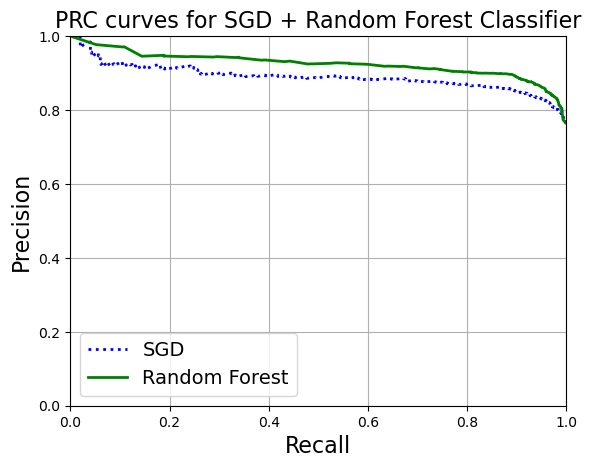

In [40]:
# plot precision-recall (PR) curve for SGD classifier and random forest classifier
plt.plot(recalls, precisions, "b:", linewidth=2, label="SGD")
plt.plot(recalls_forest, precisions_forest, "g-", linewidth=2, label="Random Forest")
# beautify the figure: add grid, legend, axis, labels,
plt.grid(True)
plt.legend(loc="lower left", fontsize=14)
plt.xlabel("Recall", fontsize=16)
plt.ylabel("Precision", fontsize=16)
plt.title("PRC curves for SGD + Random Forest Classifier", fontsize=16)
plt.axis([0, 1, 0, 1])
plt.show()

# As seen from above, the random forest's classifier curve looks much better than SGD classifier.

In [41]:
# print F1 score for random forest classifier
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5  # positive proba ≥ 50%
f1_score(p_np, y_train_pred_forest)

0.9016541353383458

In [42]:
# print ROC-AUC score for random forest classifier
roc_auc_score(p_np, y_scores_forest)

0.8300806969648306

In [43]:
print("The random forest curve looks much better than SGD.")

The random forest curve looks much better than SGD.


In [44]:
# calculate accuracy score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("Accuracy score: ", accuracy_score(p_np, y_train_pred_forest))

# calculate precision score
print("Precision score: ", precision_score(p_np, y_train_pred_forest))

# calculate recall score
print("Recall score: ", recall_score(p_np, y_train_pred_forest))

# calculate F1 score
print("F1 score: ", f1_score(p_np, y_train_pred_forest))

# calculate sensitivity score
from sklearn.metrics import confusion_matrix

confusion_matrix(p_np, y_train_pred_forest)

Accuracy score:  0.8396272682687592
Precision score:  0.8492917847025496
Recall score:  0.9608974358974359
F1 score:  0.9016541353383458


array([[ 213,  266],
       [  61, 1499]])

In [45]:
# calculate probability threshold to maximize F1 score using numpy argmax() function
# calculate F1 score for each threshold
f1_scores = []
for threshold in thresholds_forest:
    y_train_pred_forest = (y_scores_forest >= threshold)
    f1_scores.append(f1_score(p_np, y_train_pred_forest))

# calculate threshold that maximizes F1 score
threshold_forest_maxf1 = thresholds_forest[np.argmax(f1_scores)]
threshold_forest_maxf1

0.545

In [46]:
# at threshold = 0.545, calculate accuracy, sensitivity, specificity, precision score, recall score, and F1-score
y_train_pred_forest = (y_scores_forest >= 0.545)
accuracy_score(p_np, y_train_pred_forest)
precision_score(p_np, y_train_pred_forest)
recall_score(p_np, y_train_pred_forest)
f1_score(p_np, y_train_pred_forest)

# summarize results and print
print("Accuracy score: ", accuracy_score(p_np, y_train_pred_forest))
print("Precision score: ", precision_score(p_np, y_train_pred_forest))
print("Recall score: ", recall_score(p_np, y_train_pred_forest))
print("F1 score: ", f1_score(p_np, y_train_pred_forest))

# calculate confusion matrix
cm = confusion_matrix(p_np, y_train_pred_forest)
cm

Accuracy score:  0.8464933791074056
Precision score:  0.8597807270628968
Recall score:  0.9551282051282052
F1 score:  0.9049498937139386


array([[ 236,  243],
       [  70, 1490]])

In [47]:
# calculate threshold that will give a precision of 50%
threshold_forest_prec50 = thresholds_forest[np.argmax(precisions_forest >= 0.5)]
threshold_forest_prec50

0.0

In [48]:
# at threshold = 0.0, calculate accuracy, sensitivity, specificity, precision score, recall score, and F1-score
y_train_pred_forest = (y_scores_forest >= 0.0)
accuracy_score(p_np, y_train_pred_forest)
precision_score(p_np, y_train_pred_forest)
recall_score(p_np, y_train_pred_forest)
f1_score(p_np, y_train_pred_forest)

# summarize results and print
print("Accuracy score: ", accuracy_score(p_np, y_train_pred_forest))
print("Precision score: ", precision_score(p_np, y_train_pred_forest))
print("Recall score: ", recall_score(p_np, y_train_pred_forest))
print("F1 score: ", f1_score(p_np, y_train_pred_forest))

# calculate confusion matrix
cm = confusion_matrix(p_np, y_train_pred_forest)
cm

Accuracy score:  0.7650809220205983
Precision score:  0.7650809220205983
Recall score:  1.0
F1 score:  0.8669074742984162


array([[   0,  479],
       [   0, 1560]])